In [641]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [642]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [643]:
# load dataset
df_train = pd.read_csv('train.csv')


In [644]:
df_train_train = df_train.sample(n=int(len(df_train) * 0.7))
df_train_test = df_train[~df_train.index.isin(df_train_train.index)]


In [645]:
train_x = list(df_train_train['description_x'].values)
train_x_1 = list(df_train_train['description_y'].values)

test_x = list(df_train_test['description_x'].values)
test_x_1 = list(df_train_test['description_y'].values)

In [646]:
from sklearn.feature_extraction.text import TfidfVectorizer

####Train tf-idf model and get  vectorized representation of sentences####

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5)#, stop_words='english')
tfidf.fit(train_x)
train_X = tfidf.transform(train_x).toarray()
test_X = tfidf.transform(test_x).toarray()
train_X_1 = tfidf.transform(train_x_1).toarray()
test_X_1 = tfidf.transform(test_x_1).toarray()


label_dict = {'True':1,'False':0}
label_train = []
label_test = []
df_train_label = np.array(df_train_train['same_security'],dtype=str)
df_test_label = np.array(df_train_test['same_security'],dtype=str)
for i in range(len(df_train_label)):
    if df_train_label[i] == 'True':
        label_train.append(1)
    else:
        label_train.append(0)
for i in range(len(df_test_label)):
    if df_test_label[i] == 'True':
        label_test.append(1)
    else:
        label_test.append(0)

In [647]:
train_X = np.concatenate([train_X,train_X_1],axis=1)
test_X = np.concatenate([test_X,test_X_1],axis=1)

In [648]:
# Convert true and false to 1 and 0
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(label_train).reshape(-1, 1))
train_Y = enc.transform(np.array(label_train).reshape(-1, 1)).toarray()
test_Y = enc.transform(np.array(label_test).reshape(-1, 1)).toarray()

In [649]:
train_X = torch.tensor(train_X,dtype=torch.float32)
train_Y = torch.tensor(train_Y,dtype=torch.float32)
test_X = torch.tensor(test_X,dtype=torch.float32)
test_Y = torch.tensor(test_Y,dtype=torch.float32)

In [650]:
print("Shape of val_x:",train_X.shape)
print("Shape of test_x:",test_X.shape)

Shape of val_x: torch.Size([1499, 492])
Shape of test_x: torch.Size([643, 492])


In [651]:
def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    confusion_matrix = np.zeros( (y_test.shape[1], y_test.shape[1]) )  
    for index, elem in enumerate(y_test):
        r, c = np.argmax(elem), y_pred[index]
        confusion_matrix[r][c] += 1
    accuracy = np.sum(np.argmax(y_test, axis=1) == y_pred) /  y_test.shape[0]
    
  
    #true positive
    TP = np.sum(np.logical_and(np.equal(np.argmax(y_test, axis=1),0),np.equal(y_pred,0)))
    #false positive
    FP = np.sum(np.logical_and(np.not_equal(np.argmax(y_test, axis=1),0),np.equal(y_pred,0)))
    
    #false negative
    FN = np.sum(np.logical_and(np.equal(np.argmax(y_test, axis=1),0),np.not_equal(y_pred,0)))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_Score = 2*precision*recall/(precision+recall)
    return confusion_matrix,accuracy,precision,recall,F1_Score

####################################################################################################

## Part 1

In [652]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        return 1/(1 + torch.exp(-x))
        
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]

        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output

                hidden = self.sigmoid(x_batch.cuda().mm(self.W1))
                output = self.sigmoid(hidden.cuda().mm(self.W2))
                
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden
                
                output_error = y_batch.cuda() - output
                loss += output_error.pow(2).sum().item()
                delta_output = output_error * output * (1 - output)
                delta_hidden = delta_output.mm(self.W2.t())* hidden*(1-hidden)
                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                delta_W2 = torch.mm(hidden.t(), delta_output) 
                delta_W1 = torch.mm(x_batch.cuda().t(), delta_hidden)
                self.W2 += delta_W2 * self.learning_rate
                self.W1 += delta_W1 * self.learning_rate
                
                ####################################################################################################

            # calculate the accuracy and save the training history
            
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y.cuda(), dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc.cpu())
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val.cuda(), dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc.cpu())
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'
                  % (i + 1, loss, train_acc, val_acc))
        

    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        hidden =  self.sigmoid(x.cuda().mm(self.W1))
        output =  self.sigmoid(hidden.mm(self.W2))
        y_pred = torch.argmax(output, dim=1)
        
        ####################################################################################################
        return y_pred
    

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
      
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]   

    yield x_batch, y_batch

In [737]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size

model = NN(learning_rate=0.01, n_iters=500, batch_size=100, hidden_size=32, device=device)
model.train(train_X,train_Y,test_X,test_Y)

####################################################################################################

epoch 1, loss 577.6290, train acc 0.755, validation acc 0.750
epoch 2, loss 555.4680, train acc 0.755, validation acc 0.750
epoch 3, loss 555.1136, train acc 0.755, validation acc 0.750
epoch 4, loss 554.7673, train acc 0.755, validation acc 0.750
epoch 5, loss 554.4202, train acc 0.755, validation acc 0.750
epoch 6, loss 554.0721, train acc 0.755, validation acc 0.750
epoch 7, loss 553.7226, train acc 0.755, validation acc 0.750
epoch 8, loss 553.3716, train acc 0.755, validation acc 0.750
epoch 9, loss 553.0188, train acc 0.755, validation acc 0.750
epoch 10, loss 552.6639, train acc 0.755, validation acc 0.750
epoch 11, loss 552.3066, train acc 0.755, validation acc 0.750
epoch 12, loss 551.9465, train acc 0.755, validation acc 0.750
epoch 13, loss 551.5831, train acc 0.755, validation acc 0.750
epoch 14, loss 551.2160, train acc 0.755, validation acc 0.750
epoch 15, loss 550.8446, train acc 0.755, validation acc 0.750
epoch 16, loss 550.4683, train acc 0.755, validation acc 0.750
e

In [738]:
confusion_matrix, accuracy,precision,recall,F1_Score = evaluator(test_Y.cpu().numpy(),model.predict(test_X).cpu().numpy())
print("Confusion matrix: \n", confusion_matrix , "\nAccuracy: ", accuracy , "\nPrecision: ", precision , "\nRecall: ", recall , "\nF1 score: ", F1_Score)


Confusion matrix: 
 [[131.  30.]
 [ 28. 454.]] 
Accuracy:  0.9097978227060654 
Precision:  0.8238993710691824 
Recall:  0.8136645962732919 
F1 score:  0.8187500000000001


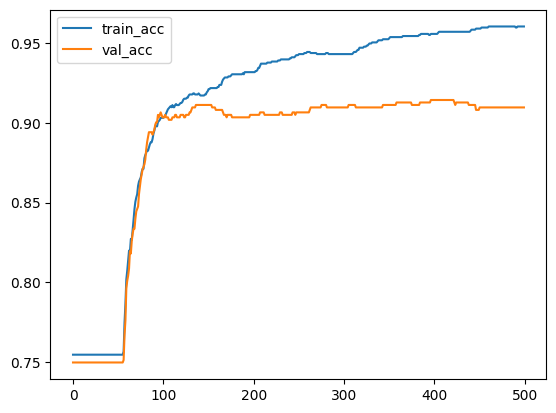

In [739]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [740]:
#df_test = pd.read_csv('test.csv')
#ttest_x = list(df_test['description_x'].values)
#ttest_x_1 = list(df_test['description_y'].values)

In [741]:


#ttest_X = tfidf.transform(ttest_x).toarray()

#ttest_X_1 = tfidf.transform(ttest_x_1).toarray()
#ttest_X = np.concatenate([ttest_X,ttest_X_1],axis=1)
#ttest_X = torch.tensor(ttest_X,dtype=torch.float32)


In [742]:
#model.predict(ttest_X)


tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,